In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from statsmodels.tsa.stattools import adfuller

warnings = warnings.filterwarnings('ignore')

df=pd.read_csv('stock_details_5_years.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29 00:00:00-05:00,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,AAPL
1,2018-11-29 00:00:00-05:00,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,MSFT
2,2018-11-29 00:00:00-05:00,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,GOOGL
3,2018-11-29 00:00:00-05:00,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,AMZN
4,2018-11-29 00:00:00-05:00,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,NVDA


In [2]:
df_allstocks = df.pivot(index='Date', columns='Company', values='Close')
df_allstocks.reset_index(inplace=True)
df_allstocks.columns.name = None
df_allstocks = df_allstocks.set_index('Date')

print(df_allstocks.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 2018-11-29 00:00:00-05:00 to 2023-11-29 00:00:00-05:00
Columns: 491 entries, A to ZTS
dtypes: float64(491)
memory usage: 4.7+ MB
None


In [3]:
# Checking df_allstocks if the different companies have different number of rows
print(df_allstocks.count())

A       1258
AAPL    1258
ABBV    1258
ABEV    1258
ABNB     747
        ... 
YUM     1258
ZBH     1258
ZM      1163
ZS      1258
ZTS     1258
Length: 491, dtype: int64


In [4]:
# Define the required length
required_length = 1258

# Use the `dropna` method to drop columns with NaN values that result in series with lengths less than required_length
df_filtered_stocks = df_allstocks.dropna(axis=1, thresh=required_length)

# Ensure that the DataFrame has columns left after the operation
if df_filtered_stocks.empty:
    raise ValueError("No columns left with the required non-NaN entry count.")

# Further filter out any stocks that, despite having the threshold number of non-NaN values, might still have NaNs
df_filtered_stocks = df_filtered_stocks.loc[:, df_filtered_stocks.isnull().sum() == 0]

# Ensure that the DataFrame has columns left after the operation
if df_filtered_stocks.empty:
    raise ValueError("No columns left after removing columns with any NaN values.")

# Now proceed with your code and ensure you're not calling any reduction operations on empty arrays


In [5]:
missing_values = df_filtered_stocks.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

In [6]:
def fractional_difference(series, d, threshold=1e-5):
    """
    Computes the fractionally differenced series using a fast algorithm.
    The threshold determines the cut-off weight for the weights vector.
    """
    # Initialization
    weights = [1]
    k = 1
    while True:
        weight = -weights[-1] * (d - k + 1) / k
        if abs(weight) < threshold:
            break
        weights.append(weight)
        k += 1

    weights = np.array(weights[::-1])
    diff_series = np.convolve(series, weights, mode='full')[:len(series)]
    diff_series[:len(weights)] = np.nan  # due to the lag from convolution, set the first few values to nan
    return diff_series

In [13]:
# Assuming df_allstocks is your dataframe
cumsum_df = df_filtered_stocks.cumsum()

min_d_values = {}
p_values = {}

def find_min_d(series, d_start, d_end, d_increment, p_value_threshold=0.05):
    """
    Applies the ADF test to fractionally differenced series for a range of d values.
    Returns the minimum d that leads to a p-value below the threshold.
    Adjusts max_lags based on series length to avoid NameError.
    """
    min_p_value = 1.0
    min_d = None
    for d in np.arange(d_start, d_end, d_increment):
        # Fractionally difference the series
        fd_series = fractional_difference(series, d)
        
        # Drop NaN values generated by differencing
        fd_series = fd_series[~np.isnan(fd_series)]
        
        # Check if the series is empty after removing NaNs
        if fd_series.size == 0:
            continue  # Skip this iteration if fd_series is empty
        
        ntrend = 1  # Assuming a constant in the regression
        max_allowed_lag = max(0, (len(fd_series) // 2 - ntrend - 1))
        
        # Dynamically determine max_lags within bounds
        dynamic_max_lags = min(20, max_allowed_lag)  # 20 is chosen arbitrarily, adjust as needed

        # Apply the ADF test with a suitable max_lag
        p_value = adfuller(fd_series, maxlag=dynamic_max_lags, autolag='AIC')[1]
        
        if p_value < min_p_value:
            min_p_value = p_value
            min_d = d
        
        if p_value < p_value_threshold:
            return d, p_value
    
    return min_d, min_p_value  # Return the best found, even if not under the threshold

# Iterating over each stock with corrected function call
min_d_values = {}
p_values = {}

for stock in cumsum_df.columns:
    series = cumsum_df[stock].values
    
    # Ensure the series is not empty
    if len(series) == 0:
        continue

    min_d, p_value = find_min_d(series, d_start=0, d_end=1, d_increment=0.01, p_value_threshold=0.05)
    
    if min_d is not None:
        min_d_values[stock] = min_d
        p_values[stock] = p_value
        # Apply fractional differencing with the found min_d
        fd_series = fractional_difference(series, min_d)
        # Storing the fractionally differenced series
        df_filtered_stocks[f'FD_{stock}'] = fd_series
    else:
        print(f"Could not find a suitable d value for stock {stock} that satisfies the ADF p-value criterion.")

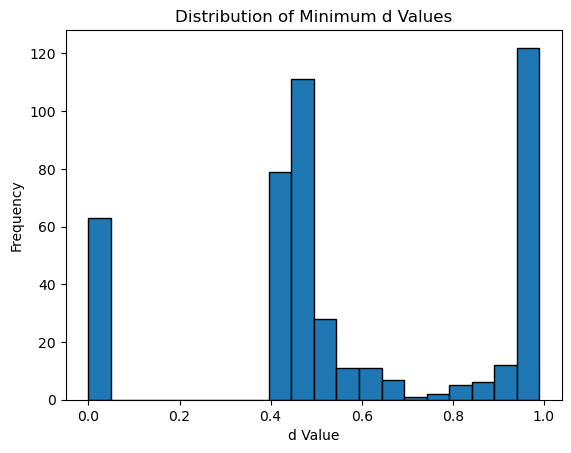

In [15]:
import matplotlib.pyplot as plt

# Assuming min_d_values is a dictionary with stocks as keys and their respective min d values as values
d_values = list(min_d_values.values())

plt.hist(d_values, bins=20, edgecolor='black')
plt.title('Distribution of Minimum d Values')
plt.xlabel('d Value')
plt.ylabel('Frequency')
plt.show()


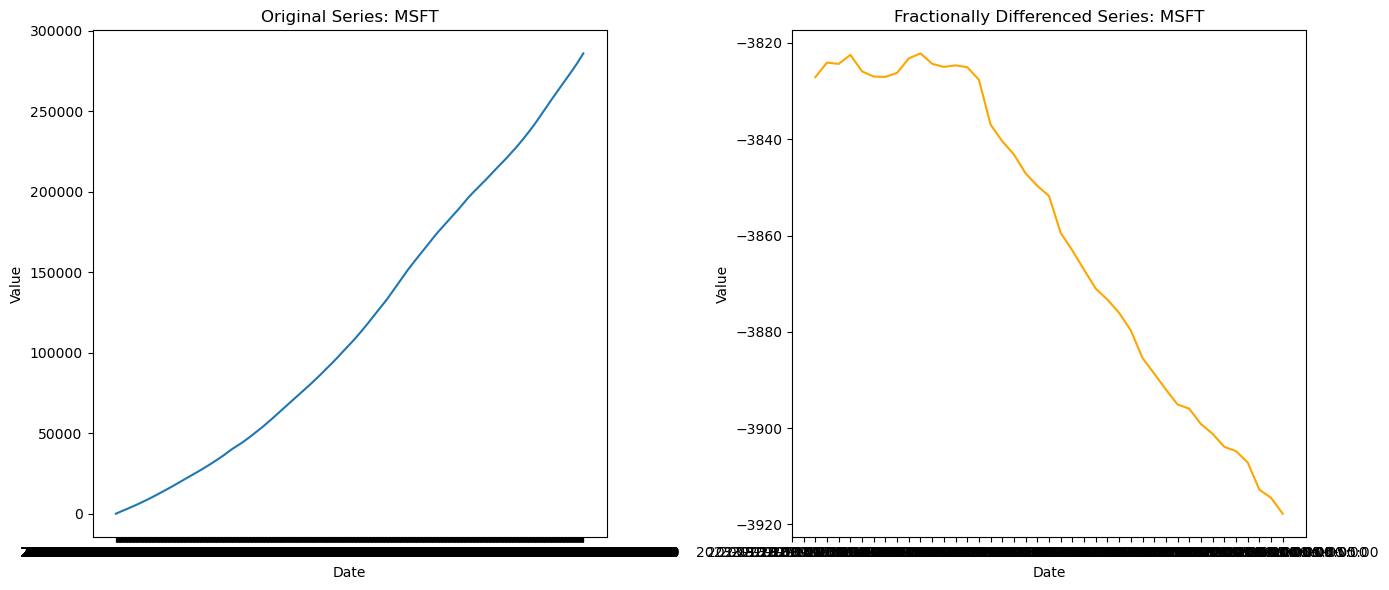

In [18]:
# Example: Plot original and fractionally differenced series for a specific stock
stock_example = 'MSFT'

original_series = cumsum_df[stock_example]
fd_series = df_filtered_stocks[f'FD_{stock_example}']

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(original_series, label='Original')
plt.title(f'Original Series: {stock_example}')
plt.xlabel('Date')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(fd_series, label='Fractionally Differenced', color='orange')
plt.title(f'Fractionally Differenced Series: {stock_example}')
plt.xlabel('Date')
plt.ylabel('Value')

plt.tight_layout()
plt.show()
